# Q-Learning with Kernel Function Approximation

This notebook shows the function approximation reinforcement learning algorithm, Q-Learning applied to the MountainCar problem (it also works on Acrobat and CartPole) from Open AI's gym. This algorithm is designed to work on state spaces larger than the tabular Q-Learning algorithm. It achieves this by representing the states by feature vectors, $x(s) = (x_{1}(s), x_{2}(s), ..., x_{n}(s))^T$, which is a vector with smaller size than the set of all states. 
Now the action value function can be estimated with function approximation, given by:
$$\hat{q}(s, a, \bold{w}) \approx q_{\pi}(s, a)$$
, where $\bold{w}$ is the parameter vector.

The parameter vector can then be updated using gradient descent:
$$\bold{w}_{t+1} = \bold{w}_{t} + \alpha [R_{t+1} + \gamma \max_{a}\hat{q}(S_{t + 1}, a, \bold{w}_{t}) - \hat{q}(S_{t}, A_{t}, \bold{w}_{t})] \nabla \hat{q}(S_{t}, A_{t}, \bold{w}_{t})$$
, where $\bold{w}$ is the parameter vector, $\alpha$ is the step size, $\gamma$ is the discount rate, $R$ is the reward, $\nabla$ is the gradient operator, $S$ is the state, $A$ is the action and $\hat{q}$ is the approximate action-value function.

For more information on function approximation see section 10 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of Q-learning function approximation see: [Q-Learning Value Function Approximation Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb).

In [154]:
import gym
import numpy as np
import sklearn
import sklearn.pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from gym.wrappers import RecordVideo
from IPython.display import Video

In [155]:
# Type of environment, options include:
# MountainCar-v0, Acrobot-v1, CartPole-v1
ENV_TYPE = "MountainCar-v0"

# Save videos from training
SAVE_VIDEOS = False

In [156]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

if SAVE_VIDEOS:
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder='./videos/',
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix="q_learning_fa"
        )

# Number of possible actions
num_actions = env.action_space.n

/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/ubuntu20/code/rl-tabular-algorithms/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Create Features Using Radial Basis Functions

In [157]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([np.float64(env.observation_space.sample()) for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

## Create Action-Value Function Approximator

In [158]:
def convert_to_features(state, scaler):
    """
    Converts the state to a feature representation.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]    


In [159]:
# List of linear action-value fuction approximators (one for each action)
Q = []

for _ in range(num_actions):
    linear_model = SGDRegressor(learning_rate="constant")
    # We need to call partial_fit once to initialize the model
    # or we get a NotFittedError when trying to make a prediction
    # This is quite hacky.
    state, info = env.reset()
    linear_model.partial_fit([convert_to_features(state, scaler)], [0])
    Q.append(linear_model)    



In [160]:
def predict_returns(state, Q):
    features = convert_to_features(state, scaler)
    estimated_returns = []
    for linear_model in Q:
        estimated_returns.append(linear_model.predict([features])[0])

    return np.array(estimated_returns)

## Create An $\epsilon$-Greedy Policy 

In [161]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Use function approximation to get the estimated returns for the actions in the current state
    estimated_returns = predict_returns(state, Q)
    # Find the best action
    best_action = np.argmax(estimated_returns)
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [162]:
# Number of episodes to train on
episodes = 41
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Probability of taking a non-greedy action
epsilon = 0.001

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    while not terminated:
        # Select the action following the epsilon-greedy policy
        action_dist = policy_fn(state, Q, epsilon, num_actions)
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)

        # Update the expected return for the action-value function
        next_estimated_returns = predict_returns(next_state, Q)
        td_target = reward + gamma * np.max(next_estimated_returns)
        Q[action].partial_fit([convert_to_features(state, scaler)], [td_target])
 
        G += reward
        state = next_state

    returns.append(G)

    if episode % 1 == 0:
        print(f'Episode: {episode} Return: {G}')

Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-0.mp4
Episode: 1 Return: -3458.0
Episode: 2 Return: -939.0
Episode: 3 Return: -1314.0
Episode: 4 Return: -575.0
Episode: 5 Return: -371.0
Episode: 6 Return: -420.0
Episode: 7 Return: -437.0
Episode: 8 Return: -368.0
Episode: 9 Return: -284.0
Episode: 10 Return: -245.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-10.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-10.mp4
Episode: 11 Return: -467.0
Episode: 12 Return: -201.0
Episode: 13 Return: -407.0
Episode: 14 Return: -149.0
Episode: 15 Return: -169.0
Episode: 16 Return: -165.0
Episode: 17 Return: -224.0
Episode: 18 Return: -235.0
Episode: 19 Return: -241.0
Episode: 20 Return: -158.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-20.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-20.mp4
Episode: 21 Return: -160.0
Episode: 22 Return: -164.0
Episode: 23 Return: -160.0
Episode: 24 Return: -156.0
Episode: 25 Return: -222.0
Episode: 26 Return: -239.0
Episode: 27 Return: -184.0
Episode: 28 Return: -154.0
Episode: 29 Return: -169.0
Episode: 30 Return: -147.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-30.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-30.mp4
Episode: 31 Return: -112.0
Episode: 32 Return: -127.0
Episode: 33 Return: -150.0
Episode: 34 Return: -164.0
Episode: 35 Return: -152.0
Episode: 36 Return: -112.0
Episode: 37 Return: -144.0
Episode: 38 Return: -194.0
Episode: 39 Return: -159.0
Episode: 40 Return: -139.0
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-40.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/q_learning_fa-episode-40.mp4
Episode: 41 Return: -120.0


## Plot The Results

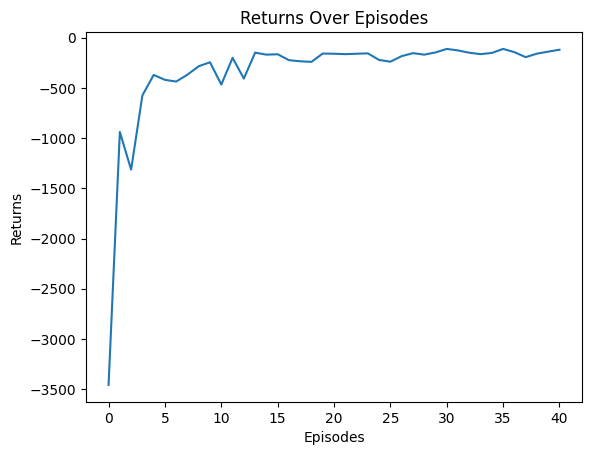

In [163]:
import matplotlib.pyplot as plt

plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Training Episode Videos

### Episode 0

In [164]:
Video("./videos/q_learning_fa-episode-0.mp4")

### Episode 10

In [166]:
Video("./videos/q_learning_fa-episode-10.mp4")

### Episode 20

In [168]:
Video("./videos/q_learning_fa-episode-20.mp4")

### Episode 30

In [170]:
Video("./videos/q_learning_fa-episode-30.mp4")

### Episode 40

In [172]:
Video("./videos/q_learning_fa-episode-40.mp4")

## Render Final Model On An Example

In [173]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(ENV_TYPE, render_mode="human")
state, info = env.reset(seed=100)
G = 0
num_steps = 0
terminated = False
truncated = False

while not terminated and not truncated:
    estimated_returns = predict_returns(state, Q)
    action = np.argmax(estimated_returns) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: -87.0, Steps Taken: 87
